<a href="https://colab.research.google.com/github/IbrahemAmar/ML-Exercises-PyTorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [22]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.8.0+cu126'

#Data (preparing and loading)

In [23]:
#Create known parameters

weight = 0.7
bias = 0.3

#Create
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias


In [24]:
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

###Split data into training and test sets(most important in ML)

Creating a training and test set with our data.

In [25]:
# Create train/test split

train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [26]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


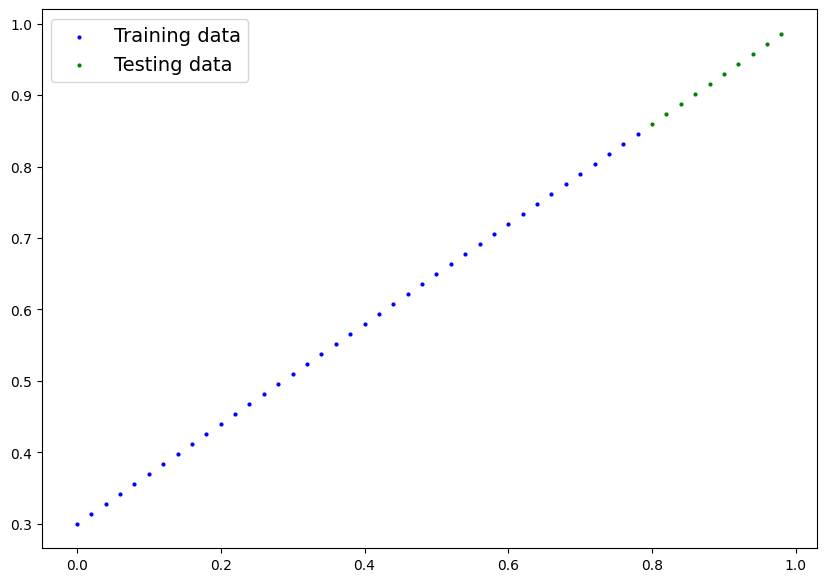

In [27]:
plot_predictions();

## Build model,

First PyTorch model!

what our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

how does it do so?
through two main algorithms:

1.Gradient descent

2.Backpropagation

In [28]:
#Create linear regression model class

class LinearRegressionModel (nn.Module):  # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float, # <- PyTorch loves float32 by default
                                                requires_grad=True)) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float, # <- PyTorch loves float32 by default
                                            requires_grad=True)) # <- can we update this value with gradient descent?))

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)


###PyTorch model building essentials

*nn.Module contains the larger building blocks (layers)

*nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))

*forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)

*torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

###Checking the contents of a PyTorch model

Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using .parameters().

In [29]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [30]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

###Making predictions using torch.inference_mode()

To check this we can pass it the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

In [31]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [32]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

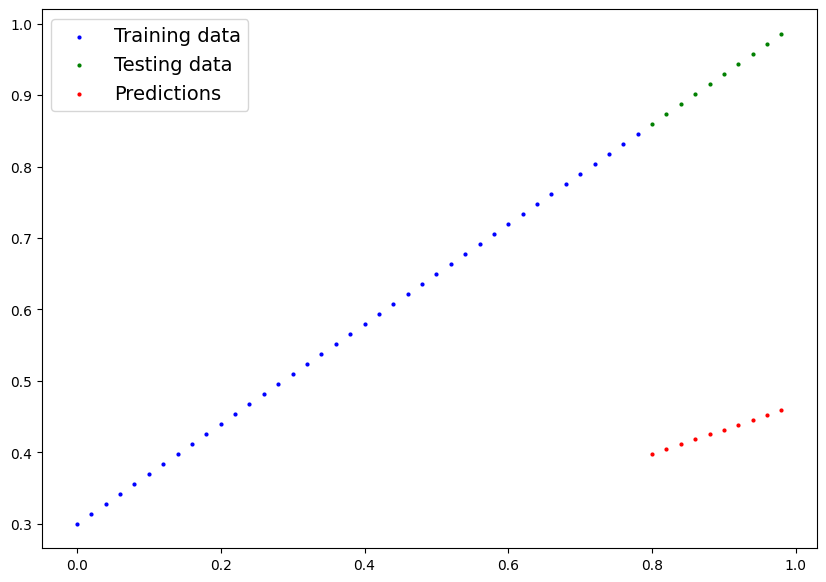

In [33]:
plot_predictions(predictions=y_preds)

# Traing model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters..

one way to mesaure how poor or how wrong your models predictions is to use Loss function. ( cost function , criterion)

* **Loss function:** Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better.

* **Optimizer:** Tells your model how to update its internal parameters to best lower the loss.


In [34]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

#Building a training loop (+ testing loop) in PyTorch

0. Loop through the data
1. Forward pass ( this involves data moving through our models 'forward()'  functions (propagation))
2. Calculate the loss ( compare forward pass predictions to ground truth labels )
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [39]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# 0. Loop through the data
for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode(): # Turns off gradient tracking &and more behiend the scenes
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss)
            test_loss_values.append(test_loss)
            print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss} ")
            # Print out model state_dict()
            print(model_0.state_dict())


Epoch: 0 | Loss: 0.024458957836031914 | Test Loss: 0.05646304413676262 
OrderedDict({'weights': tensor([0.5800]), 'bias': tensor([0.3503])})
Epoch: 10 | Loss: 0.021020207554101944 | Test Loss: 0.04819049686193466 
OrderedDict({'weights': tensor([0.5972]), 'bias': tensor([0.3433])})
Epoch: 20 | Loss: 0.01758546568453312 | Test Loss: 0.04060482233762741 
OrderedDict({'weights': tensor([0.6141]), 'bias': tensor([0.3358])})
Epoch: 30 | Loss: 0.014155393466353416 | Test Loss: 0.03233227878808975 
OrderedDict({'weights': tensor([0.6313]), 'bias': tensor([0.3288])})
Epoch: 40 | Loss: 0.010716589167714119 | Test Loss: 0.024059748277068138 
OrderedDict({'weights': tensor([0.6485]), 'bias': tensor([0.3218])})
Epoch: 50 | Loss: 0.0072835334576666355 | Test Loss: 0.016474086791276932 
OrderedDict({'weights': tensor([0.6654]), 'bias': tensor([0.3143])})
Epoch: 60 | Loss: 0.0038517764769494534 | Test Loss: 0.008201557211577892 
OrderedDict({'weights': tensor([0.6826]), 'bias': tensor([0.3073])})
Epo

/tmp/ipython-input-2764309487.py:2: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label ="Traing loss")


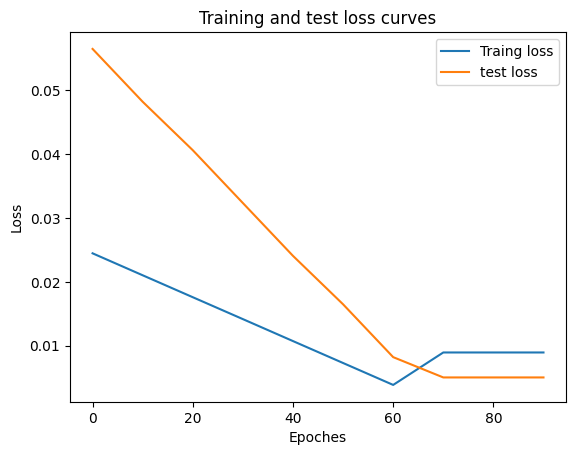

In [47]:
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label ="Traing loss")
plt.plot(epoch_count, test_loss_values, label ="test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoches")
plt.legend();

In [42]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

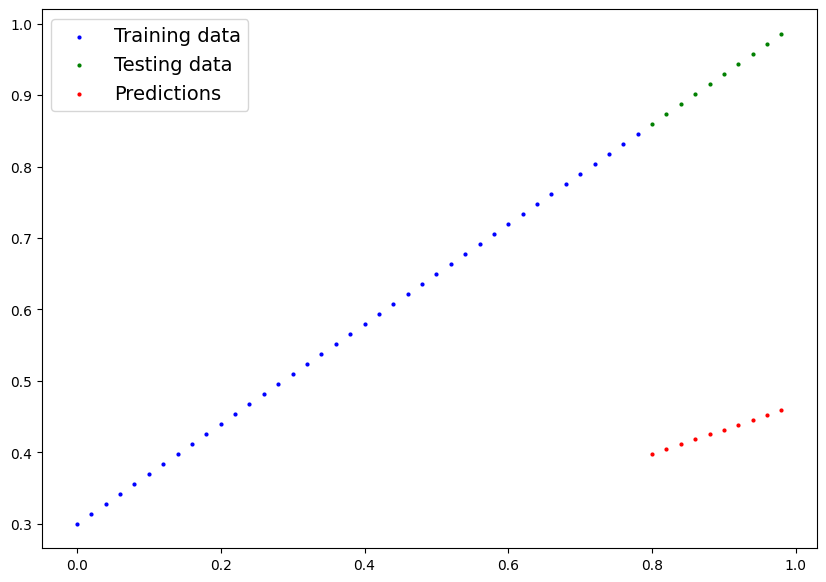

In [37]:
plot_predictions(predictions=y_preds)

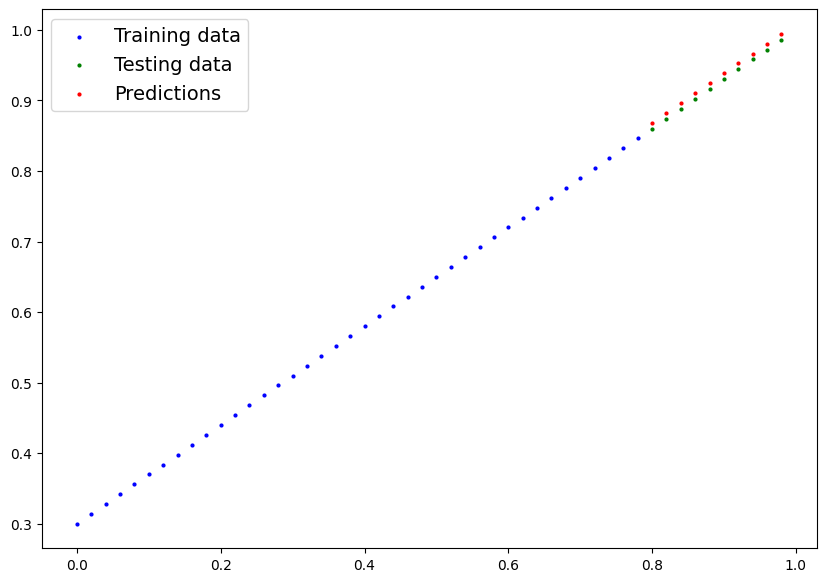

In [43]:
plot_predictions(predictions=y_preds_new)